# Introduction

   **Chennai** also known as **Madras** is the capital of the **Indian state of Tamil Nadu**. Chennai is among the **most-visited Indian cities by foreign tourists**. Tourism-guide publisher **Lonely Planet** named Chennai as **one of the top ten cities in the world to visit in 2015**. Chennai was ranked the **43rd-most visited city in the world** for the year 2015. The **Quality of Living Survey** rated Chennai as the **safest city in India**. Chennai attracts 45 percent of health tourists visiting India, and 30 to 40 percent of domestic health tourists. **National Geographic** mentioned Chennai as the **only South Asian city** to feature in its 2015 **"Top 10 food cities"** list. Chennai was also named the **ninth-best cosmopolitan city in the world** by Lonely Planet. In October 2017, Chennai was added to the **UNESCO Creative Cities Network (UCCN) list for its rich musical tradition**.

### Business Problem

In recent days, the **tourism of this beautiful city has decreased**. Tourism not only adds to the country's economy but is a core part of income. How do we increase tourism and bring back the popularity of the city? In-order to achieve this, we need the **tourists to have a good experience and moreover a personalized one**. We can achieve this with the help of data science.

### Target Audience

With all this tourist attraction taken into account, a system that can find a place suitable for the tourist to visit during their stay will be helpful. Our goal is to **identify places based on their rating & pricing** and make it visible to the tourists in-order for them **to choose a place to visit based on their budget and based on the venue's rating**.This will eventually increase the tourism level of Chennai.
   
   We will be clustering the places to visit based on the data we recieve from the **Foursquare API** & **Zomato API**.

# Data

Our objective is to search within a **5km radius of Chennai** located at the **Latitude : 13.0827° N** & **Longitude : 80.2707° E**. Using the FoursquareAPI & ZomatoAPI the data mentioned below is retrieved. Based on the Venue Name, Latitude & Longitude obtained from the FoursquareAPI we request for data from the ZomatoAPI. We have collected a total of **120 Venues within a 5km radius** of the geographical co-ordinates of Chennai. Since we are using two datasets each from different API, there maybe some noise. In-order to clean this data, we are eliminating venues with latitude & longitude values more than 0.0004. On cleaning this data we are left with **75venues** to obtain a working model.

The following data has been collected from the **FoursquareAPI** :
* Venue Name
* Category
* Latitude
* Longitude

The following data has been collected from the **ZomatoAPI** :
* Average Price for Two People
* Price Range
* Rating
* Address

### Importing Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize
import requests
import folium

First we have to locate Chennai on the map, we are doing this by **providing the Latitude & Longitude co-ordinates for Chennai**.

In [2]:
chennai_latitude = 13.0827
chennai_longitude = 80.2707
print('The Geo Co-ordinates of Chennai, India are \nLatitude : {}\nLongitude : {}'.format(chennai_latitude,chennai_longitude))

The Geo Co-ordinates of Chennai, India are 
Latitude : 13.0827
Longitude : 80.2707


Now we can pinpoint the location of chennai onto the map using the latitude & longitude co-ordinates with the help of the **folium library.**

In [3]:
chennai = folium.Map(location = [chennai_latitude,chennai_longitude], zoom_start = 15)
folium.Marker([chennai_latitude,chennai_longitude]).add_to(chennai)
chennai

In-order to access the FoursquareAPI, we need to specify the developer's **Client ID, Client Secret & API Version.**

In [4]:
client_id = 'SPJ5ZZH2JCBKLK3Y5HF51JBNPK5GGGPI2J43MDND3Z3MFD2L'
client_secret = 'Y1J35FIYYFC1LUW3ATM0TVBTB1E3TVY4ALG2F2FZXSXYNCFB'
version = '20180605'

Now we define a function called **get_category_type to retrieve categories of each venue**.

In [5]:
def get_category_type(row):
    categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now with the help of a while loop, we will be requesting data from the FoursquareAPI. We must **specify the Client ID, Client Secret, API Version, Chennai-Latitude, Chennai-Longitude, Search Radius (5km) & the limit**.

In [6]:
fs_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])
radius = 5000 
limit = 100
offset = 0
total_venues = 0
while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(client_id, 
                                                                        client_secret, 
                                                                        version, 
                                                                        chennai_latitude, 
                                                                        chennai_longitude, 
                                                                        radius,
                                                                        limit,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]
    
    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)
    
    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    fs_venues = pd.concat([fs_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

fs_venues = fs_venues.reset_index(drop = True)
print("Total Number of Venues Retrieved : {}".format(total_venues))

Total Number of Venues Retrieved : 120


Now with the **venues retrieved and the data for each venue stored in the dataframe fs_venues**, we can now visualize the locations of each venue on the map with the help of the folium library.

In [7]:
fs_chennai_map = folium.Map(location = [chennai_latitude, chennai_longitude], zoom_start = 13)
for name, lat, lng in zip(fs_venues['name'], fs_venues['lat'], fs_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = 'blue',
        fill_opacity = 0.5,
        parse_html = False).add_to(fs_chennai_map)  
fs_chennai_map

Now in-order to get data about the **rating & pricing of each venue we have to use the ZomatoAPI**. We **must specify our unique user-key**. With the help of a for loop **we send a request to the ZomatoAPI with the details of latitude, longitude, ... for each venue & retrieve the rating, pricing, address, ... for the respective venue** from the ZomatoAPI. The venues are stored in a new dataframe **z_venues.**

In [8]:
headers = {'user-key': 'f7cd1d6c3bc13dc7e6a88c6ad92d7f49'}
venues_information = []

for index, row in fs_venues.iterrows():
    print("Retrieving data for venue : {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
z_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Retrieving data for venue : 1
Retrieving data for venue : 2
Retrieving data for venue : 3
Retrieving data for venue : 4
Retrieving data for venue : 5
Retrieving data for venue : 6
Retrieving data for venue : 7
Retrieving data for venue : 8
Retrieving data for venue : 9
Retrieving data for venue : 10
Retrieving data for venue : 11
Retrieving data for venue : 12
Retrieving data for venue : 13
Retrieving data for venue : 14
Retrieving data for venue : 15
Retrieving data for venue : 16
Retrieving data for venue : 17
Retrieving data for venue : 18
Retrieving data for venue : 19
Retrieving data for venue : 20
Retrieving data for venue : 21
Retrieving data for venue : 22
Retrieving data for venue : 23
Retrieving data for venue : 24
Retrieving data for venue : 25
Retrieving data for venue : 26
Retrieving data for venue : 27
Retrieving data for venue : 28
Retrieving data for venue : 29
Retrieving data for venue : 30
Retrieving data for venue : 31
Retrieving data for venue : 32
Retrieving data f

In [9]:
z_venues = z_venues.dropna()
z_venues

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Hotel Greens Gate,13.0811794166,80.2703266963,450.0,1.0,0,"12 & 13, V V Koil Street, Opposite Rippon Buil..."
1,Links,13.0797362738,80.2546387911,250.0,1.0,4.4,"22, Raja Annamalai Road, Purasavakkam, Chennai"
2,Bombay Lassi,13.0659415707,80.2711595222,100.0,1.0,4.7,"8, Bahar Agan Street, Anna Salai, Ellis Road, ..."
3,Southish,13.0555585389,80.2581954002,150.0,1.0,3.3,"Peters Colony, Sathyam Cinemas, Royapettah, Ch..."
4,Mathura Restaurant,13.0665663481,80.2690308541,500.0,2.0,4.0,"826, 2nd Floor, Tarapore Towers, Anna Salai, T..."
5,Novelty Tea House,13.0891186739,80.2788044885,300.0,1.0,4.1,"175, Mint Street, Sowcarpet, Chennai"
6,Kakada Ramprasad,13.0902623030,80.2790945023,450.0,1.0,4.4,"348/343, Ground Floor, Mint Street, Sowcarpet,..."
7,Shadhi Ka Biryani,13.0634564892,80.2778268233,350.0,1.0,0,"18/92 , Oppostie M.A.C. Cricket Stadium, CN Kr..."
8,House of Candy,13.0587462293,80.2642903849,200.0,1.0,0,"Express Avenue Mall, 2, Ground Floor, Hamleys ..."
9,The Cake World,13.0603093584,80.2545221150,500.0,2.0,3.1,"11/2, Greams Road, Near Police Station, Thousa..."


Now with the **venues retrieved and the data for each venue stored in the dataframe z_venues**, we can now visualize the locations of each venue on the map with the help of the folium library.

In [10]:
z_chennai_map = folium.Map(location = [chennai_latitude, chennai_longitude], zoom_start = 13)
for name, lat, lng in zip(z_venues['venue'], z_venues['latitude'], z_venues['longitude']):
    label = '{}'.format(name)
    latitude = float(lat)
    longitude = float(lng)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'orange',
        fill = True,
        fill_color = 'orange',
        fill_opacity = 0.5,
        parse_html = False).add_to(z_chennai_map)  
z_chennai_map

With the help of a lambda function we are **rounding the latitude & longitude values to 4  decimal digits** for both the ZomatoAPI data & the FoursquareAPI data.

In [11]:
fs_venues['lat'] = fs_venues['lat'].apply(lambda lat: round(float(lat), 4))
fs_venues['lng'] = fs_venues['lng'].apply(lambda lng: round(float(lng), 4))
z_venues['latitude'] = z_venues['latitude'].apply(lambda lat: round(float(lat), 4))
z_venues['longitude'] = z_venues['longitude'].apply(lambda lng: round(float(lng), 4))

Since we are using **2 dataframes -> fs_venues & z_venues**, there some **unwanted repeated data with slight deviations** in location. Therefor to remove this error we are **removing venues with a latitude & longitude difference greater than 0.0004.**

In [12]:
combine = pd.concat([fs_venues, z_venues], axis = 1)
combine['latitude_difference'] = combine['latitude'] - combine['lat']
combine['longitude_difference'] = combine['longitude'] - combine['lng']
filtered_venues = combine[(abs(combine['latitude_difference']) <= 0.0004) & (abs(combine['longitude_difference']) <= 0.0004)].reset_index(drop = True)
filtered_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,latitude_difference,longitude_difference
0,National Durbar Hotel,Indian Restaurant,13.0813,80.2706,Hotel Greens Gate,13.0812,80.2703,450.0,1.0,0,"12 & 13, V V Koil Street, Opposite Rippon Buil...",-0.0001,-0.0003
1,Links,Snack Place,13.0800,80.2546,Links,13.0797,80.2546,250.0,1.0,4.4,"22, Raja Annamalai Road, Purasavakkam, Chennai",-0.0003,0.0000
2,Bombay Lassi,Dessert Shop,13.0660,80.2712,Bombay Lassi,13.0659,80.2712,100.0,1.0,4.7,"8, Bahar Agan Street, Anna Salai, Ellis Road, ...",-0.0001,0.0000
3,Mathura (woodland group),Indian Restaurant,13.0666,80.2690,Mathura Restaurant,13.0666,80.2690,500.0,2.0,4.0,"826, 2nd Floor, Tarapore Towers, Anna Salai, T...",0.0000,0.0000
4,Kakada Ramprasad,Indian Restaurant,13.0904,80.2791,Kakada Ramprasad,13.0903,80.2791,450.0,1.0,4.4,"348/343, Ground Floor, Mint Street, Sowcarpet,...",-0.0001,0.0000
5,Express Avenue,Shopping Mall,13.0587,80.2642,House of Candy,13.0587,80.2643,200.0,1.0,0,"Express Avenue Mall, 2, Ground Floor, Hamleys ...",0.0000,0.0001
6,Fruit Shop On Greams Road,Juice Bar,13.0604,80.2544,The Cake World,13.0603,80.2545,500.0,2.0,3.1,"11/2, Greams Road, Near Police Station, Thousa...",-0.0001,0.0001
7,Nicky's Cafe & Fine Pastries,Café,13.0639,80.2598,Nicky's Cafe & Fine Pastries,13.0636,80.2597,750.0,2.0,4.2,"Fagun Mansion, 74, Ethiraj Salai, Egmore, Chennai",-0.0003,-0.0001
8,Hotel Welcome,Hotel,13.0857,80.2546,Welcome Hotel,13.0856,80.2545,250.0,1.0,4.5,"112/241, Purasawalkam High Road, Purasavakkam,...",-0.0001,-0.0001
9,Shree Mithai,Indian Restaurant,13.0721,80.2479,Shree Mithai,13.0722,80.2479,300.0,1.0,4.5,"18, Dr TV Road, Chetpet, Chennai",0.0001,0.0000


Since we have a dataframe result with repeated columns after combining of both the dataframes, we must remove the repeated ones.

In [13]:
filtered_venues = filtered_venues.drop(columns = ['name', 'lat', 'lng', 'latitude_difference', 'longitude_difference'])

**Removing** the venues which have **0 rating (They are unrated)**.

In [14]:
filtered_venues = filtered_venues[filtered_venues['rating'] != 0.0]
print("Total venues available: {}".format(filtered_venues.shape[0]))
filtered_venues.head()

Total venues available: 75


,categories,venue,latitude,longitude,price_for_two,price_range,rating,address
1,Snack Place,Links,13.0797,80.2546,250.0,1.0,4.4,"22, Raja Annamalai Road, Purasavakkam, Chennai"
2,Dessert Shop,Bombay Lassi,13.0659,80.2712,100.0,1.0,4.7,"8, Bahar Agan Street, Anna Salai, Ellis Road, ..."
3,Indian Restaurant,Mathura Restaurant,13.0666,80.2690,500.0,2.0,4.0,"826, 2nd Floor, Tarapore Towers, Anna Salai, T..."
4,Indian Restaurant,Kakada Ramprasad,13.0903,80.2791,450.0,1.0,4.4,"348/343, Ground Floor, Mint Street, Sowcarpet,..."
6,Juice Bar,The Cake World,13.0603,80.2545,500.0,2.0,3.1,"11/2, Greams Road, Near Police Station, Thousa..."


**Renaming columns**, so the data can be understood easily.

In [15]:
data = filtered_venues.rename(columns = {'categories':'Category','venue':'Venue Name','latitude':'Latitude','longitude':'Longitude','price_for_two':'Price','price_range':'Price Range','rating':'Rating','address':'Venue Address'})
data

,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address
1,Snack Place,Links,13.0797,80.2546,250.0,1.0,4.4,"22, Raja Annamalai Road, Purasavakkam, Chennai"
2,Dessert Shop,Bombay Lassi,13.0659,80.2712,100.0,1.0,4.7,"8, Bahar Agan Street, Anna Salai, Ellis Road, ..."
3,Indian Restaurant,Mathura Restaurant,13.0666,80.2690,500.0,2.0,4.0,"826, 2nd Floor, Tarapore Towers, Anna Salai, T..."
4,Indian Restaurant,Kakada Ramprasad,13.0903,80.2791,450.0,1.0,4.4,"348/343, Ground Floor, Mint Street, Sowcarpet,..."
6,Juice Bar,The Cake World,13.0603,80.2545,500.0,2.0,3.1,"11/2, Greams Road, Near Police Station, Thousa..."
7,Café,Nicky's Cafe & Fine Pastries,13.0636,80.2597,750.0,2.0,4.2,"Fagun Mansion, 74, Ethiraj Salai, Egmore, Chennai"
8,Hotel,Welcome Hotel,13.0856,80.2545,250.0,1.0,4.5,"112/241, Purasawalkam High Road, Purasavakkam,..."
9,Indian Restaurant,Shree Mithai,13.0722,80.2479,300.0,1.0,4.5,"18, Dr TV Road, Chetpet, Chennai"
10,Movie Theater,Blur Cafe,13.0554,80.2579,850.0,2.0,4.0,"8, 5th Floor, Sathyam Cinemas Complex, Thiruvi..."
11,Seafood Restaurant,The Marina,13.0672,80.2523,1600.0,3.0,4.5,"39, College Road, Nungambakkam, Chennai"


Visualizing the cleaned data on a map with the help of the folium library.

In [16]:
filtered_chennai_map = folium.Map(location = [chennai_latitude, chennai_longitude], zoom_start = 13)
for name, lat, lng in zip(data['Venue Name'], data['Latitude'],data['Longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'black',
        fill = True,
        fill_color = 'grey',
        fill_opacity = 0.7,
        parse_html = False).add_to(filtered_chennai_map)  
filtered_chennai_map

This **concludes the data gathering & data cleaning phase**. We have combined the data we acquired from both the dataframes -> ZomatoAPI & FoursquareAPI. We removed the data which had slight differences in latitude & longitude. We removed venues which had 0 rating (unrated). The obtained dataframe **"data"** is visualized in the above map.

# Methodology

In this project, we are focusing on **venues tourists can visit during their stay in Chennai**. We will be directing our efforts to **analyze venues with similar ratings & pricing**. We are limiting our analysis to a **5Km range** around Chennai.

In first step we have collected the required **data: location, rating & pricing of every venue within 5km of Chennai**. We have cleaned the data by **removing repeated locations & unrated venues**.

Second step in our analysis will be calculation and exploration of '**Rating & Pricing**' of each venue. With the help of **bar plots** we will be visualizing **the Number of venue categories & Number of ratings within 5Km of Chennai**. We will also visualize the **venue count vs. pricing** with the help of a **scatter plot**.

In third and final step we will focus on **identifying groups with the help of clustering (Affinity Propagation Clustering)**. The clusters will then be created and will describe **a group of venues with similar ratings & price ranges**. This will **help the tourist to identify where he or she would want to visit according to the venue's rating & the tourist's budget**.

# Analysis

Lets perform some basic exploratory data analysis & try to acquire some additional information about the venues. First lets **visualize the number of venue categories within the 5km radius of Chennai**.

<BarContainer object of 35 artists>

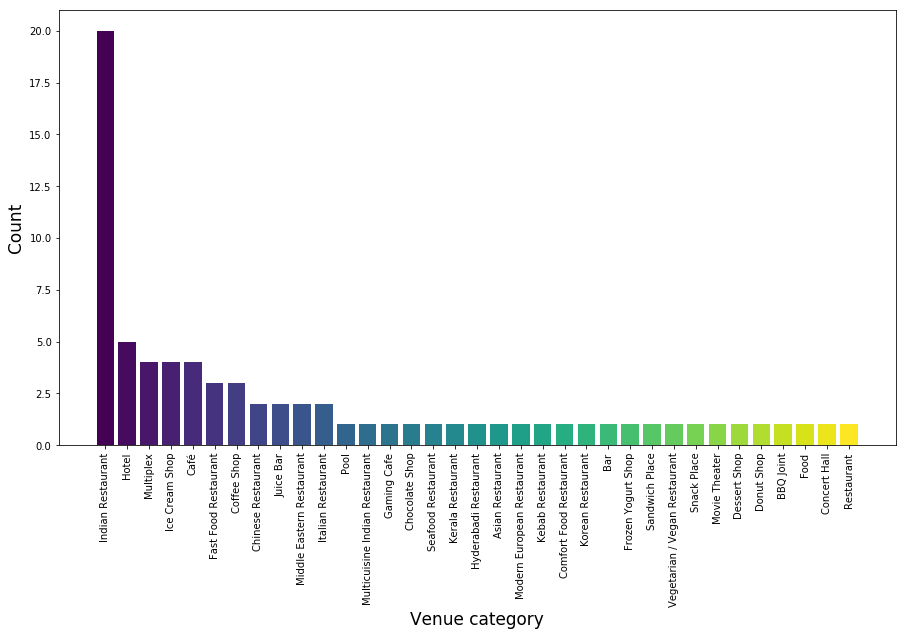

In [17]:
venue_graph = data['Category'].value_counts()
colors = cm.viridis(np.linspace(0, 1, len(venue_graph.index)))
plt.figure(figsize = (15, 8))
plt.xticks(rotation = 90)
plt.xlabel('Venue category', fontsize = 17)
plt.ylabel('Count', fontsize = 17)
plt.bar(venue_graph.index, venue_graph.values, color = colors)

Let us replace the categories with numerical values :
* **Leisure places - 0**
* **Restaurants - 1**
* **Quick eats -2**

In [33]:
data = data.replace(['Multiplex','Hotel','Bar','Movie Theater','Gaming Cafe','Park','Concert Hall','Pool','Café'],0)
data = data.replace(['Indian Restaurant','Fast Food Restaurant','Middle Eastern Restaurant','Restaurant','Italian Restaurant','Chinese Restaurant','Modern European Restaurant','BBQ Joint',
                     'Vegetarian / Vegan Restaurant','Seafood Restaurant','Food','Kebab Restaurant','Hyderabadi Restaurant','Multicuisine Indian Restaurant','Korean Restaurant','Kerala Restaurant','Asian Restaurant','Comfort Food Restaurant'],1)
data = data.replace(['Ice Cream Shop','Coffee Shop','Juice Bar','Dessert Shop','Bakery','Frozen Yogurt Shop','Donut Shop','Chocolate Shop','Snack Place','Sandwich Place'],2)
data['Category'].value_counts()

1    42
0    18
2    15
Name: Category, dtype: int64

From the above bar plot, it is obvious that there are a **lot of Indian Restaurants within the 5Km radius**. This is **good for tourists who want to try the local cuisine & experience the culture of Chennai**.

Now lets **visualize the number of counts for each rating**, where  **0 is the least & 5 is the highest rating**.

Text(0, 0.5, 'Count')

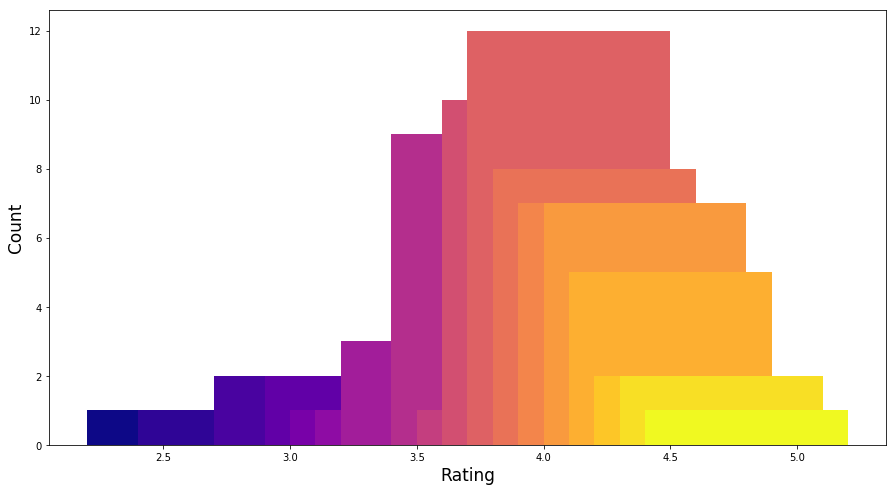

In [19]:
data['Rating'] = data['Rating'].astype(float)
rating = data['Rating'].value_counts().sort_index()
plt.figure(figsize = (15,8))
plt.bar(rating.index, rating.values, color = cm.plasma(np.linspace(0, 1, len(rating.index))))
plt.xlabel('Rating', fontsize = 17)
plt.ylabel('Count', fontsize = 17)

From the above bar plot, we can conclude that there are a **lot of venues with an average rating of 3.5-4.5**. This is **good for tourism, the rating indicates the customer/visitor satisfaction of the venue**.

In-order **to visualize the rating on the map, let us group the Rating into bins** where :
* 0-2.5    is **Bad**
* 2.5-3.2   is **Average**
* 3.2-4.2 is **Good**
* 4.2-5.0 is **Excellent**

In [20]:
bins = [0, 2.5, 3.2, 4.2, 5.0]
labels = ['Bad', 'Average', 'Good', 'Excellent']
data['Review'] = pd.cut(data['Rating'].astype(float), bins = bins, labels = labels, include_lowest = True)
data

,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address,Review
1,Snack Place,Links,13.0797,80.2546,250.0,1.0,4.4,"22, Raja Annamalai Road, Purasavakkam, Chennai",Excellent
2,2,Bombay Lassi,13.0659,80.2712,100.0,1.0,4.7,"8, Bahar Agan Street, Anna Salai, Ellis Road, ...",Excellent
3,1,Mathura Restaurant,13.0666,80.2690,500.0,2.0,4.0,"826, 2nd Floor, Tarapore Towers, Anna Salai, T...",Good
4,1,Kakada Ramprasad,13.0903,80.2791,450.0,1.0,4.4,"348/343, Ground Floor, Mint Street, Sowcarpet,...",Excellent
6,2,The Cake World,13.0603,80.2545,500.0,2.0,3.1,"11/2, Greams Road, Near Police Station, Thousa...",Average
7,0,Nicky's Cafe & Fine Pastries,13.0636,80.2597,750.0,2.0,4.2,"Fagun Mansion, 74, Ethiraj Salai, Egmore, Chennai",Good
8,0,Welcome Hotel,13.0856,80.2545,250.0,1.0,4.5,"112/241, Purasawalkam High Road, Purasavakkam,...",Excellent
9,1,Shree Mithai,13.0722,80.2479,300.0,1.0,4.5,"18, Dr TV Road, Chetpet, Chennai",Excellent
10,0,Blur Cafe,13.0554,80.2579,850.0,2.0,4.0,"8, 5th Floor, Sathyam Cinemas Complex, Thiruvi...",Good
11,1,The Marina,13.0672,80.2523,1600.0,3.0,4.5,"39, College Road, Nungambakkam, Chennai",Excellent


Now we assign colors according to their rating bins. The corresponding colors are :
* 0-2.5     (Bad) is **red**
* 2.5-3.2   (Average) is **green**
* 3.2-4.2 (Good) is **lightblue**
* 4.2-5.0 (Excellent) is **darkblue**

We assign the colors to the marker and plot the markers on the map with the help of the folium library.

In [21]:
color_map = {'Bad': 'red', 'Average': 'green', 'Good': 'lightblue', 'Excellent': 'darkblue '}

chennai_map_review = folium.Map(location = [chennai_latitude,chennai_longitude], zoom_start = 13)

for name, address, latitude, longitude, rating in zip(data['Venue Name'], 
                                                          data['Venue Address'], 
                                                          data['Latitude'], 
                                                          data['Longitude'], 
                                                          data['Review']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating]),
        popup = label).add_to(chennai_map_review)  
chennai_map_review

Now lets **visualize the venue count against price for two** with the help of a **scatter plot**.

Text(0, 0.5, 'Venue Count')

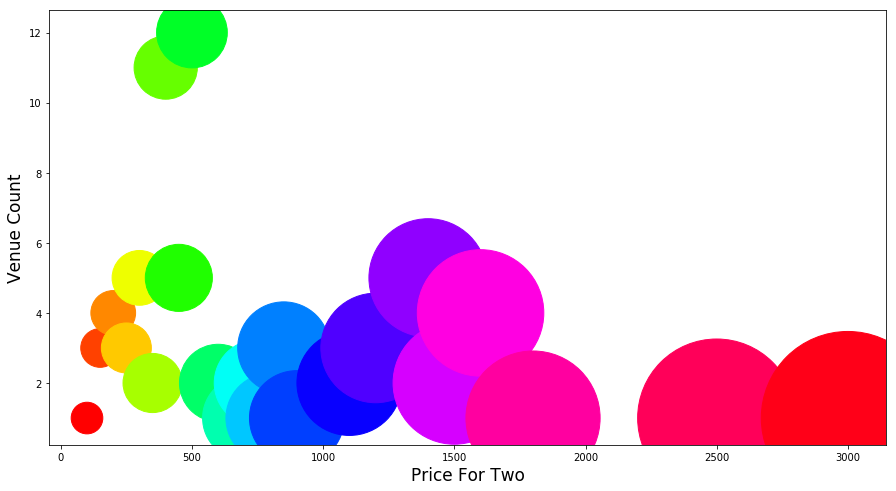

In [22]:
average_prices = data['Price'].value_counts().sort_index()
plt.figure(figsize = (15, 8))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.hsv(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price For Two", fontsize = 17)
plt.ylabel("Venue Count", fontsize = 17)

Now lets **map the venues based on their price**, Color Code :
* Cheap is **darkblue**
* Average is **lightblue**
* Affordable is **green**
* Expensive is **red**

In [23]:
bins = [0,500,1000,2000,4000]
labels = ['Cheap', 'Average', 'Affordable', 'Expensive']
data['Cost'] = pd.cut(data['Price'].astype(float), bins = bins, labels = labels, include_lowest = True)
data
color_map = {'Cheap': 'darkblue', 'Average': 'lightblue', 'Affordable': 'green', 'Expensive': 'red'}

chennai_map_prices = folium.Map(location = [chennai_latitude,chennai_longitude], zoom_start = 13)

for name, address, latitude, longitude, cost in zip(data['Venue Name'], 
                                                           data['Venue Address'], 
                                                           data['Latitude'], 
                                                           data['Longitude'], 
                                                           data['Cost']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[cost]),
        popup = label).add_to(chennai_map_prices)  
chennai_map_prices

# Clustering

We will now be clustering the data with the help of **Affinity Propagation Clustering**.

In [62]:
from sklearn.cluster import AffinityPropagation

We now fit the data to the AffinityPropagation Clustering model.

In [63]:
clustering = AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False).fit(clustering_data)

In [50]:
data.insert(0, 'Affinity Cluster No.', clustering.labels_)
data['Affinity Cluster No.'].values

array([5, 5, 6, 6, 6, 3, 5, 5, 3, 2, 6, 6, 2, 5, 2, 5, 2, 2, 3, 6, 0, 1,
       6, 1, 5, 2, 3, 6, 6, 6, 6, 6, 5, 6, 1, 6, 5, 2, 2, 1, 2, 6, 6, 3,
       2, 2, 4, 1, 6, 6, 5, 6, 2, 6, 6, 6, 3, 6, 5, 3, 6, 6, 6, 6, 6, 6,
       3, 6, 5, 5, 5, 6, 5, 6, 5], dtype=int64)

Let us now map the clustered data based on their clusters on to the Chennai map with the help of the folium library.

In [53]:
chennai_clusters_map = folium.Map(location = [chennai_latitude,chennai_longitude], zoom_start = 13)
color_map = { 0: 'purple', 1: 'red', 2: 'black',3:'blue',4:'green',5:'orange',6:'grey'}
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(data['Venue Name'], 
                                                        data['Venue Address'], 
                                                        data['Affinity Cluster No.'], 
                                                        data['Latitude'], 
                                                        data['Longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(chennai_clusters_map)

for index, cluster in enumerate(clustering.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 1).add_to(chennai_clusters_map)
chennai_clusters_map

### Cluster - 0

In [64]:
result = data[data['Affinity Cluster No.'] == 0]
rows = result.shape[0]
print("Cluster 0 :\nAverage Price for two : {:.02f}\nAverage Rating : {:.02f}\nNo of Venues : {}".
      format(result['Price'].mean(), result['Rating'].astype(float).mean(),rows))
result.head(10).reset_index(drop = True)

Cluster 0 :
Average Price for two : 2500.00
Average Rating : 4.20
No of Venues : 1


,Affinity Cluster No.,Cluster Number,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address,Review,Cost
0,0,2,0,Beyond Indus - Taj Club House,13.0613,80.2639,2500.0,4.0,4.2,"Taj Club House Hotel, 2, Club House Road, Ann...",Good,Expensive


### Cluster - 1

In [66]:
result = data[data['Affinity Cluster No.'] == 1]
rows = result.shape[0]
print("Cluster 1 :\nAverage Price for two : {:.02f}\nAverage Rating : {:.02f}\nNo of Venues : {}".
      format(result['Price'].mean(), result['Rating'].astype(float).mean(),rows))
result.head(10).reset_index(drop = True)

Cluster 1 :
Average Price for two : 1160.00
Average Rating : 4.26
No of Venues : 5


,Affinity Cluster No.,Cluster Number,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address,Review,Cost
0,1,0,1,Dynasty,13.0666,80.2429,1200.0,3.0,4.0,"Harrisons Hotel, 315, Valluvar Kottam High Roa...",Good,Affordable
1,1,0,2,Tuscana Pizzeria,13.0609,80.2495,1200.0,3.0,4.0,"19, 3rd Street, Wallace Garden Road, Nungambak...",Good,Affordable
2,1,0,1,Nasi And Mee,13.0609,80.2497,1200.0,3.0,4.6,"18/24, Yafa Towers, Khader Nawaz Khan Road, Th...",Excellent,Affordable
3,1,0,0,The Brew Room - The Savera Hotel,13.0458,80.2611,1100.0,3.0,4.4,"The Savera Hotel, 146, RK Salai, Mylapore, Che...",Excellent,Affordable
4,1,0,1,Jalpaan,13.0572,80.2553,1100.0,3.0,4.3,"21, Opposite MRF Building, Greams Road, Nungam...",Excellent,Affordable


### Cluster - 2

In [67]:
result = data[data['Affinity Cluster No.'] == 2]
rows = result.shape[0]
print("Cluster 2 :\nAverage Price for two : {:.02f}\nAverage Rating : {:.02f}\nNo of Venues : {}".
      format(result['Price'].mean(), result['Rating'].astype(float).mean(),rows))
result.head(10).reset_index(drop = True)

Cluster 2 :
Average Price for two : 1516.67
Average Rating : 4.28
No of Venues : 12


,Affinity Cluster No.,Cluster Number,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address,Review,Cost
0,2,0,1,The Marina,13.0672,80.2523,1600.0,3.0,4.5,"39, College Road, Nungambakkam, Chennai",Excellent,Affordable
1,2,0,0,Symphony - Ramada,13.0770,80.2650,1800.0,3.0,4.0,"Ramada, 2A Poniamman Koil Street,Gandhi Irwin ...",Good,Affordable
2,2,0,2,Sandy's Chocolate Laboratory,13.0610,80.2484,1400.0,3.0,4.4,"16, Wallace Garden, 2nd Street, Nungambakkam, ...",Excellent,Affordable
3,2,0,0,Chili's American Grill & Bar,13.0588,80.2640,1400.0,3.0,4.8,"49 & 50 L, Express Avenue Mall, White's Road, ...",Excellent,Affordable
4,2,0,0,Wild Garden Cafe - Amethyst,13.0573,80.2592,1400.0,3.0,4.3,"Whites Road, Royapettah, Chennai",Excellent,Affordable
5,2,0,1,Little Italy,13.0607,80.2475,1500.0,3.0,4.1,"112, Eldorado Building, Nungambakkam High Road...",Good,Affordable
6,2,0,0,Entrée,13.0587,80.2630,1400.0,3.0,3.9,"E Hotel, Gate Number 1, Lobby Level, Pattulos ...",Good,Affordable
7,2,0,1,Cream Centre,13.0669,80.2462,1600.0,3.0,4.2,"45, College Road, Near Madras Alliance Francai...",Good,Affordable
8,2,0,0,Sera - The Tapas Bar & Restaurant,13.0458,80.2581,1600.0,3.0,4.3,"71, Cathedral Road, Gopalapuram, Chennai",Excellent,Affordable
9,2,0,1,Hoppipola,13.0530,80.2484,1400.0,3.0,4.1,"The Spring Hotel, 11, Kodambakkam High Road, N...",Good,Affordable


### Cluster - 3

In [68]:
result = data[data['Affinity Cluster No.'] == 3]
rows = result.shape[0]
print("Cluster 3 :\nAverage Price for two : {:.02f}\nAverage Rating : {:.02f}\nNo of Venues : {}".
      format(result['Price'].mean(), result['Rating'].astype(float).mean(),rows))
result.head(10).reset_index(drop = True)

Cluster 3 :
Average Price for two : 806.25
Average Rating : 4.09
No of Venues : 8


,Affinity Cluster No.,Cluster Number,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address,Review,Cost
0,3,1,0,Nicky's Cafe & Fine Pastries,13.0636,80.2597,750.0,2.0,4.2,"Fagun Mansion, 74, Ethiraj Salai, Egmore, Chennai",Good,Average
1,3,1,0,Blur Cafe,13.0554,80.2579,850.0,2.0,4.0,"8, 5th Floor, Sathyam Cinemas Complex, Thiruvi...",Good,Average
2,3,1,0,Blur Cafe,13.0554,80.2579,850.0,2.0,4.0,"8, 5th Floor, Sathyam Cinemas Complex, Thiruvi...",Good,Average
3,3,1,2,Haagen Dazs,13.0599,80.2483,800.0,2.0,4.4,"16/32, KNK Road, Nungambakkam, Chennai",Excellent,Average
4,3,1,2,Starbucks Coffee,13.0587,80.2649,700.0,2.0,4.1,"Ground Floor, Express Avenue Mall, Whites Road...",Good,Average
5,3,1,1,Zaitoon,13.0835,80.2255,900.0,2.0,4.1,"119, D Block, 1st Main Road, Chintamani, Oppos...",Good,Average
6,3,1,1,Ente Keralam,13.0420,80.2559,750.0,2.0,4.1,"1, Poes Garden, Kasturi Estate, 1st Street, Al...",Good,Average
7,3,1,1,Buhari,13.0840,80.2245,850.0,2.0,3.8,"59, Block C, 1st Avenue, Anna Nagar East, Chennai",Good,Average


### Cluster - 4

In [69]:
result = data[data['Affinity Cluster No.'] == 4]
rows = result.shape[0]
print("Cluster 4 :\nAverage Price for two : {:.02f}\nAverage Rating : {:.02f}\nNo of Venues : {}".
      format(result['Price'].mean(), result['Rating'].astype(float).mean(),rows))
result.head(10).reset_index(drop = True)

Cluster 4 :
Average Price for two : 3000.00
Average Rating : 4.10
No of Venues : 1


,Affinity Cluster No.,Cluster Number,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address,Review,Cost
0,4,2,0,The Leather Bar - The Park,13.053,80.25,3000.0,4.0,4.1,"The Park, 601, Nungambakkam High Road, Nungamb...",Good,Expensive


### Cluster - 5

In [71]:
result = data[data['Affinity Cluster No.'] == 5]
rows = result.shape[0]
print("Cluster 5 :\nAverage Price for two : {:.02f}\nAverage Rating : {:.02f}\nNo of Venues : {}".
      format(result['Price'].mean(), result['Rating'].astype(float).mean(),rows))
result.head(10).reset_index(drop = True)

Cluster 5 :
Average Price for two : 225.00
Average Rating : 4.05
No of Venues : 16


,Affinity Cluster No.,Cluster Number,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address,Review,Cost
0,5,1,2,Links,13.0797,80.2546,250.0,1.0,4.4,"22, Raja Annamalai Road, Purasavakkam, Chennai",Excellent,Cheap
1,5,1,2,Bombay Lassi,13.0659,80.2712,100.0,1.0,4.7,"8, Bahar Agan Street, Anna Salai, Ellis Road, ...",Excellent,Cheap
2,5,1,0,Welcome Hotel,13.0856,80.2545,250.0,1.0,4.5,"112/241, Purasawalkam High Road, Purasavakkam,...",Excellent,Cheap
3,5,1,1,Shree Mithai,13.0722,80.2479,300.0,1.0,4.5,"18, Dr TV Road, Chetpet, Chennai",Excellent,Cheap
4,5,1,1,Nair Mess,13.0643,80.2775,200.0,1.0,4.3,"22, Mohammed Abdullah 2nd Street, Opposite Che...",Excellent,Cheap
5,5,1,0,Southish,13.0556,80.2582,150.0,1.0,3.3,"Peters Colony, Sathyam Cinemas, Royapettah, Ch...",Good,Cheap
6,5,1,1,ID,13.0552,80.2578,300.0,1.0,4.2,"8, 1st Floor, Sathyam Cinemas Complex, Thiruvi...",Good,Cheap
7,5,1,1,Charminar Biriyani Centre,13.0534,80.2699,300.0,1.0,4.1,"91, Dr. Besant Road, Near Meesapet Market, Roy...",Good,Cheap
8,5,1,1,Ajanabi,13.0678,80.2568,250.0,1.0,4.2,"149, Fountain Plaza, Pantheon Road, Egmore, Ch...",Good,Cheap
9,5,1,2,ibaco,13.0497,80.2402,200.0,1.0,4.1,"No:140,Habibullah Road,Opp To Vidhyodaya Schoo...",Good,Cheap


### Cluster - 6

In [72]:
result = data[data['Affinity Cluster No.'] == 6]
rows = result.shape[0]
print("Cluster 6 :\nAverage Price for two : {:.02f}\nAverage Rating : {:.02f}\nNo of Venues : {}".
      format(result['Price'].mean(), result['Rating'].astype(float).mean(),rows))
result.head(10).reset_index(drop = True)

Cluster 6 :
Average Price for two : 454.69
Average Rating : 3.91
No of Venues : 32


,Affinity Cluster No.,Cluster Number,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address,Review,Cost
0,6,1,1,Mathura Restaurant,13.0666,80.2690,500.0,2.0,4.0,"826, 2nd Floor, Tarapore Towers, Anna Salai, T...",Good,Cheap
1,6,1,1,Kakada Ramprasad,13.0903,80.2791,450.0,1.0,4.4,"348/343, Ground Floor, Mint Street, Sowcarpet,...",Excellent,Cheap
2,6,1,2,The Cake World,13.0603,80.2545,500.0,2.0,3.1,"11/2, Greams Road, Near Police Station, Thousa...",Average,Cheap
3,6,1,1,Kabab Corner,13.0600,80.2541,450.0,1.0,4.5,"12/1, Opposite Royal Enfield Showroom, Egmore,...",Excellent,Cheap
4,6,1,2,Krispy Kreme,13.0589,80.2639,400.0,1.0,4.3,"Upper Ground Floor, Express Avenue, Whites Roa...",Excellent,Cheap
5,6,1,1,Buhari,13.0663,80.2684,600.0,2.0,3.8,"83, Anna Salai, Mount Road, Triplicane, Chennai",Good,Average
6,6,1,2,Cream & Fudge,13.0609,80.2515,500.0,2.0,4.1,"10, Khader Nawaz Khan Road, Opposite Evoluzion...",Good,Cheap
7,6,1,1,Fusilli Reasons,13.0818,80.2488,400.0,1.0,4.6,"2/64, Ormes Main Road, Kilpauk, Chennai",Excellent,Cheap
8,6,1,0,Curry on Fire by Sketch,13.0585,80.2473,400.0,1.0,3.8,"41, Ground Floor, Anugraha, Near Taj Coromande...",Good,Cheap
9,6,1,1,Al-Najeeb Nawab Of Kebab,13.0879,80.2434,500.0,2.0,4.1,"Families Complex, Medavakkam Tank Road, Kilpau...",Good,Cheap


# Results & Discussion

Our analysis provides an insight on the venues within a 5km radius of Chennai. We had found that **most venues were located in and around Nungambakkam & Thousand Lights**. The **most common venue category was Indian restaurants, tourists can enjoy the indian cuisine & Chennai's culture**. The city of **chennai mostly consists of venues rated between 3.5 & 4.5**, this is evidence that the **venues are well taken care of and satisfy their customers**. **Most venues had their prices between 500 Rupees & 1500 Rupees**, this is also evidence that the city of **Chennai is an affordable place where you can have a great time at decent prices**.

# Conclusion

**The whole purpose of this analysis is to provide information to the tourists visiting Chennai to make decisions based on their preferences** and also **promote tourism in Chennai**. We initially **acquired data from FoursquareAPI & ZomatoAPI**. we **cleaned the data** by combining the two datasets & removing venues with similar latitude & longitude co-ordinates. We **dropped venues which were not given ratings** yet. We the **visualized the data in the form of bar plots, scatter plots & maps** to come the conclusions mentioned in the results section. We then **grouped the data into 3 clusters with the help of Affinity Propagation Clustering**. The description for each cluster is also mentioned above in the results section. In the end this information will only act as a guide or insight to the tourist. **The tourist is the one who will make the final decision on where they want to visit based on the rating, pricing, location etc.**